# AWS-ASDI
EDA on the NOAA Global Historical Climatology Network Daily Dataset. This dataset contains over 200 years worth of climate data, and we will analyze the dataset through the use of data science tools that are scalable (modin and NumS). Because the tools we use are scalable, we are able to run the same code on a laptop and cluster of nodes. Before getting started, make sure you set `num_cpus` in `ray_init()` to the number of physical cores on the CPU running this notebook for optimal performance, otherwise Ray might automatically set it to logical cores that include hyperthreading.

Confirm everything is installed through:
```sh
pip3 install -r requirements
```

In [257]:
import ray
ray.init(ignore_reinit_error=True, num_cpus=32, _temp_dir="/home/brian/external/aws-asdi/ray_temp");
import modin.pandas as pd
import pandas
from nums import numpy as nps
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os

2021-07-20 20:35:34,237	INFO worker.py:746 -- Calling ray.init() again after it has already been called.


## Downloading the data and organization
https://registry.opendata.aws/noaa-ghcn/

Can use AWS CLI to speed things up by downloading it locally.

To view files:
```sh
aws s3 ls s3://noaa-ghcn-pds/ --no-sign-request
```

To download locally (*about 100GB of free data is needed on disk*):
To view files:
```sh
mkdir data
aws s3 cp --recursive s3://noaa-ghcn-pds/ --no-sign-request data
```

If downloading will take too much storage space, we can run this notebook completely off of memory, by setting the `local` tag to `False` in some function arguments.

File directory should look like this:
```
├── data/
├── figures/
├── eda.ipynb
├── README.md
└── requirements.txt
```

Documentation is here: https://docs.opendata.aws/noaa-ghcn-pds/readme.html

Here, we test downloading a `.csv` file directly from the AWS s3 bucket to memory.

In [2]:
%%time
### Getting started
climate_2020 = pd.read_csv('s3://noaa-ghcn-pds/csv/2020.csv', header=None)
climate_2020.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
climate_2020["YEAR/MONTH/DAY"] = pd.to_datetime(climate_2020["YEAR/MONTH/DAY"], format="%Y%m%d")

CPU times: user 10.1 s, sys: 2.44 s, total: 12.6 s
Wall time: 1min 2s


## Global Variables and DataFrames
Some variables and DataFrames that will be useful in parsing out data.

In [237]:
all_elements = ['ACMC', 'ACMH', 'ACSC', 'ACSH', 'AWDR', 'AWND', 'DAEV', 'DAPR', 'DASF', 'DATN', 'DATX', 'DAWM',
                'DWPR', 'EVAP', 'FMTM', 'FRGB', 'FRGT', 'FRTH', 'GAHT', 'MDEV', 'MDPR', 'MDSF', 'MDTN', 'MDTX', 
                'MDWM', 'MNPN', 'MXPN', 'PGTM', 'PSUN']

# frequent elements that have 500 or more data points using
# inventory["ELEMENT"].value_counts()
#
# >>>
#['PRCP', 'SNOW', 'MDPR', 'SNWD', 'DAPR', 'TMAX', 'TMIN', 'WESD', 'WESF', 'WT01', 'WT03', 'TOBS', 'WT05', 'WT04', 'WT11', 'DWPR', 'WT06', 'MDSF', 'TAVG', 'WT14', 'WT08', 'WT16', 'WT18', 'DASF', 'WT09', 'WT07', 'WSFG', 'WDFG', 'PGTM', 'WT10', 'AWND', 'WDMV', 'WT02', 'EVAP', 'WDF2', 'WSF2', 'WSF5', 'WDF5', 'FMTM', 'TSUN', 'DAEV', 'MDEV', 'MDTN', 'DATN', 'MDWM', 'DAWM', 'DATX', 'MDTX', 'MXPN', 'MNPN', 'WT13']

#TODO, add more elements...

In [209]:
# Global variables
elements = ["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]
years = list(range(1763, 2022))
local = True #Change this flag to False to download data off of s3 storage directly
#TODO, refactor code to be changed by only this variable

For inventory, data is stored like this:

```
Variable	Columns	Type
ID	1-11	CHARACTER
LATITUDE	13-20	REAL
LONGITUDE	22-30	REAL
ELEMENT	32-35	CHARACTER
FIRSTYEAR	37-40	INTEGER
LASTYEAR	42-45	INTEGER
```

Sample query
```
ACW00011604  17.1167  -61.7833 TMAX 1949 1949
```

In [217]:
inventory = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-inventory.txt', widths=[12, 9, 10, 4, 5, 5], header=None)
inventory.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEMENT", "FIRSTYEAR", "LASTYEAR"]
inventory

CALL: list_objects_v2 - ({},) - {'Bucket': 'noaa-ghcn-pds', 'Prefix': 'ghcnd-inventory.txt', 'Delimiter': '/', 'MaxKeys': 1}
Event before-parameter-build.s3.ListObjectsV2: calling handler <function set_list_objects_encoding_type_url at 0x7f5a03f05050>
Event before-parameter-build.s3.ListObjectsV2: calling handler <function validate_bucket_name at 0x7f5a03f7ed40>
Event before-parameter-build.s3.ListObjectsV2: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fda66590>>
Event before-parameter-build.s3.ListObjectsV2: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fdd7c050>>
Event before-parameter-build.s3.ListObjectsV2: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fdec5110>>
Event before-parameter-build.s3.ListObjectsV2: calling handler <bound method S3ArnParamHand

Event needs-retry.s3.ListObjectsV2: calling handler <botocore.retryhandler.RetryHandler object at 0x7f59fd6a80d0>
No retry needed.
Event needs-retry.s3.ListObjectsV2: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event needs-retry.s3.ListObjectsV2: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event after-call.s3.ListObjectsV2: calling handler <function decode_list_object_v2 at 0x7f5a03f05170>
CALL: list_objects_v2 - ({},) - {'Bucket': 'noaa-ghcn-pds', 'Prefix': 'ghcnd-inventory.txt', 'Delimiter': '/', 'MaxKeys': 1}
Event before-parameter-build.s3.ListObjectsV2: calling handler <function set_list_objects_encoding_type_url at 0x7f5a03f05050>
Event before-parameter-build.s3.ListObjectsV2: calling handler <function validate_bucket_name at 0x7f5a03f7ed40>
Event before-parameter-build.s3.ListObjectsV

Response body:
b'<?xml version="1.0" encoding="UTF-8"?>\n<ListBucketResult xmlns="http://s3.amazonaws.com/doc/2006-03-01/"><Name>noaa-ghcn-pds</Name><Prefix>ghcnd-inventory.txt</Prefix><KeyCount>1</KeyCount><MaxKeys>1</MaxKeys><Delimiter>/</Delimiter><EncodingType>url</EncodingType><IsTruncated>false</IsTruncated><Contents><Key>ghcnd-inventory.txt</Key><LastModified>2021-06-24T11:05:39.000Z</LastModified><ETag>&quot;279b1d5918b51b33977745f2954f4a70&quot;</ETag><Size>32412152</Size><StorageClass>STANDARD</StorageClass></Contents></ListBucketResult>'
Event needs-retry.s3.ListObjectsV2: calling handler <botocore.retryhandler.RetryHandler object at 0x7f59fd6a80d0>
No retry needed.
Event needs-retry.s3.ListObjectsV2: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event needs-retry.s3.ListObjectsV2: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3

Event choose-signer.s3.ListObjectsV2: calling handler <bound method ClientCreator._default_s3_presign_to_sigv2 of <aiobotocore.client.AioClientCreator object at 0x7f59fce6e250>>
Event choose-signer.s3.ListObjectsV2: calling handler <bound method ClientCreator._default_s3_presign_to_sigv2 of <aiobotocore.client.AioClientCreator object at 0x7f59fce6e250>>
Event choose-signer.s3.ListObjectsV2: calling handler <function set_operation_specific_signer at 0x7f5a03f7ea70>
Event before-sign.s3.ListObjectsV2: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fc56c410>>
Checking for DNS compatible bucket for: https://s3.amazonaws.com/noaa-ghcn-pds?list-type=2&prefix=ghcnd-inventory.txt&delimiter=%2F&max-keys=1&encoding-type=url
URI updated to: https://noaa-ghcn-pds.s3.amazonaws.com/?list-type=2&prefix=ghcnd-inventory.txt&delimiter=%2F&max-keys=1&encoding-type=url
Event before-sign.s3.ListObjectsV2: calling handler <bound method S3Endpo

Event request-created.s3.GetObject: calling handler <bound method AioRequestSigner.handler of <aiobotocore.signers.AioRequestSigner object at 0x7f59fd6f5fd0>>
Event choose-signer.s3.GetObject: calling handler <function set_operation_specific_signer at 0x7f5a03f7ea70>
Event before-sign.s3.GetObject: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8490>>
Checking for DNS compatible bucket for: https://s3.amazonaws.com/noaa-ghcn-pds/ghcnd-inventory.txt
URI updated to: https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt
Event before-sign.s3.GetObject: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8410>>
Sending http request: <AWSPreparedRequest stream_output=True, method=GET, url=https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt, headers={'Range': b'bytes=0-5251071', 'If-Match': b'"279b1d5918b51b33977745f2954f4a70"', 'User-Agent': b'Botoc

Event request-created.s3.ListObjectsV2: calling handler <bound method AioRequestSigner.handler of <aiobotocore.signers.AioRequestSigner object at 0x7f59fd6f5fd0>>
Event choose-signer.s3.ListObjectsV2: calling handler <function set_operation_specific_signer at 0x7f5a03f7ea70>
Event before-sign.s3.ListObjectsV2: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8490>>
Checking for DNS compatible bucket for: https://s3.amazonaws.com/noaa-ghcn-pds?list-type=2&prefix=ghcnd-inventory.txt&delimiter=%2F&max-keys=1&encoding-type=url
URI updated to: https://noaa-ghcn-pds.s3.amazonaws.com/?list-type=2&prefix=ghcnd-inventory.txt&delimiter=%2F&max-keys=1&encoding-type=url
Event before-sign.s3.ListObjectsV2: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8410>>
Sending http request: <AWSPreparedRequest stream_output=False, method=GET, url=https://noaa-ghcn-pds.s3.ama

Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fd6a8590>>
Event before-parameter-build.s3.GetObject: calling handler <function generate_idempotent_uuid at 0x7f5a03f7eb90>
Event before-call.s3.GetObject: calling handler <function add_expect_header at 0x7f5a03f030e0>
Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event before-call.s3.GetObject: calling handler <function inject_api_version_header_if_needed at 0x7f5a03f05440>
Making request for OperationModel(name=GetObject) with params: {'url_path': '/noaa-ghcn-pds/ghcnd-inventory.txt', 'query_string': {}, 'method': 'GET', 'headers': {'Range': 'byte

Fetch: noaa-ghcn-pds/ghcnd-inventory.txt, 7268679-12511559
CALL: get_object - () - {'Bucket': 'noaa-ghcn-pds', 'Key': 'ghcnd-inventory.txt', 'Range': 'bytes=7268679-12511558', 'IfMatch': '"279b1d5918b51b33977745f2954f4a70"'}
Event before-parameter-build.s3.GetObject: calling handler <function sse_md5 at 0x7f5a03f7edd0>
Event before-parameter-build.s3.GetObject: calling handler <function validate_bucket_name at 0x7f5a03f7ed40>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fd698350>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event before-parameter-build.s3.GetObj

Response body:
<StreamReader 16384 bytes>
Event needs-retry.s3.GetObject: calling handler <botocore.retryhandler.RetryHandler object at 0x7f59fd6a80d0>
No retry needed.
Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
<File-like object S3FileSystem, noaa-ghcn-pds/ghcnd-inventory.txt> read: 3038719 - 8281599
Fetch: noaa-ghcn-pds/ghcnd-inventory.txt, 8281599-13524479
CALL: get_object - () - {'Bucket': 'noaa-ghcn-pds', 'Key': 'ghcnd-inventory.txt', 'Range': 'bytes=8281599-13524478', 'IfMatch': '"279b1d5918b51b33977745f2954f4a70"'}
Event before-parameter-build.s3.GetObject: calling handler <function sse_md5 at 0x7f5a03f7edd0>
Event before-parameter-build.s3.GetObject: calling handler <function 

Sending http request: <AWSPreparedRequest stream_output=True, method=GET, url=https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt, headers={'Range': b'bytes=3038760-9294518', 'If-Match': b'"279b1d5918b51b33977745f2954f4a70"', 'User-Agent': b'Botocore/1.20.106 Python/3.7.10 Linux/5.4.0-1051-azure'}>
Response headers: HTTPHeaderDict({'x-amz-id-2': 'xf9UIrzfUDKWM4K9Zq9otXrw8fj6rK3k7RP1ot/eAX54BAYi25/tn1e/worFAeAH754awwIGXi8=', 'x-amz-request-id': 'ZQS1DWY6R8PZJ27M', 'date': 'Tue, 20 Jul 2021 19:51:37 GMT', 'last-modified': 'Thu, 24 Jun 2021 11:05:39 GMT', 'etag': '"279b1d5918b51b33977745f2954f4a70"', 'content-disposition': 'ghcnd-inventory.txt', 'accept-ranges': 'bytes', 'content-range': 'bytes 3038760-9294518/32412152', 'content-type': 'application/octet-stream', 'server': 'AmazonS3', 'content-length': '6255759'})
Response body:
<StreamReader 53795 bytes>
Event needs-retry.s3.GetObject: calling handler <botocore.retryhandler.RetryHandler object at 0x7f59fd6a80d0>
No retry needed.


Event request-created.s3.GetObject: calling handler <bound method AioRequestSigner.handler of <aiobotocore.signers.AioRequestSigner object at 0x7f59fd6f5fd0>>
Event choose-signer.s3.GetObject: calling handler <function set_operation_specific_signer at 0x7f5a03f7ea70>
Event before-sign.s3.GetObject: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8490>>
Checking for DNS compatible bucket for: https://s3.amazonaws.com/noaa-ghcn-pds/ghcnd-inventory.txt
URI updated to: https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt
Event before-sign.s3.GetObject: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8410>>
Sending http request: <AWSPreparedRequest stream_output=True, method=GET, url=https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt, headers={'Range': b'bytes=4051680-10307438', 'If-Match': b'"279b1d5918b51b33977745f2954f4a70"', 'User-Agent': 

Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event before-call.s3.GetObject: calling handler <function inject_api_version_header_if_needed at 0x7f5a03f05440>
Making request for OperationModel(name=GetObject) with params: {'url_path': '/noaa-ghcn-pds/ghcnd-inventory.txt', 'query_string': {}, 'method': 'GET', 'headers': {'Range': 'bytes=5064600-11320358', 'If-Match': '"279b1d5918b51b33977745f2954f4a70"', 'User-Agent': 'Botocore/1.20.106 Python/3.7.10 Linux/5.4.0-1051-azure'}, 'body': b'', 'url': 'https://s3.amazonaws.com/noaa-ghcn-pds/ghcnd-inventory.txt', 'context': {'client_region': 'us-east-1', 'client_config': <aiobotocore.config.AioConfig object at 0x7f59fd698050>, 'has_streaming_input': False, 'auth_type': None, 'signing': {'bucket': 'noaa-ghcn-pds'}}}
Event request-created.s3.GetObject: calling handler <bound method AioRequestSigner.handler of <aiobotocore.sig

Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fd698350>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fd6a8590>>
Event before-parameter-build.s3.GetObject: calling handler <function generate_idempotent_uuid at 0x7f5a03f7eb90>
Event before-call.s3.GetObject: calling handler <function add_expect_header at 0x7f5a03f030e0>
Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotoc

Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
<File-like object S3FileSystem, noaa-ghcn-pds/ghcnd-inventory.txt> read: 7090440 - 8103319
Fetch: noaa-ghcn-pds/ghcnd-inventory.txt, 7090440-13346199
CALL: get_object - () - {'Bucket': 'noaa-ghcn-pds', 'Key': 'ghcnd-inventory.txt', 'Range': 'bytes=7090440-13346198', 'IfMatch': '"279b1d5918b51b33977745f2954f4a70"'}
Event before-parameter-build.s3.GetObject: calling handler <function sse_md5 at 0x7f5a03f7edd0>
Event before-parameter-build.s3.GetObject: calling handler <function validate_bucket_name at 0x7f5a03f7ed40>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.

Response headers: HTTPHeaderDict({'x-amz-id-2': 'zkxZBoRTbc+Bu0CKlD7DLKR6ILlAgq/HlxjjoWgOqOkqavelO0eTCK4iZlW7hdaBKn237s/9EqQ=', 'x-amz-request-id': 'RPYAW1TWVSAB3QWG', 'date': 'Tue, 20 Jul 2021 19:51:39 GMT', 'last-modified': 'Thu, 24 Jun 2021 11:05:39 GMT', 'etag': '"279b1d5918b51b33977745f2954f4a70"', 'content-disposition': 'ghcnd-inventory.txt', 'accept-ranges': 'bytes', 'content-range': 'bytes 13346199-18589078/32412152', 'content-type': 'application/octet-stream', 'server': 'AmazonS3', 'content-length': '5242880'})
Response body:
<StreamReader 16929 bytes>
Event needs-retry.s3.GetObject: calling handler <botocore.retryhandler.RetryHandler object at 0x7f59fd6a80d0>
No retry needed.
Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS

Event choose-signer.s3.GetObject: calling handler <function set_operation_specific_signer at 0x7f5a03f7ea70>
Event before-sign.s3.GetObject: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8490>>
Checking for DNS compatible bucket for: https://s3.amazonaws.com/noaa-ghcn-pds/ghcnd-inventory.txt
URI updated to: https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt
Event before-sign.s3.GetObject: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8410>>
Sending http request: <AWSPreparedRequest stream_output=True, method=GET, url=https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt, headers={'Range': b'bytes=14359119-19601998', 'If-Match': b'"279b1d5918b51b33977745f2954f4a70"', 'User-Agent': b'Botocore/1.20.106 Python/3.7.10 Linux/5.4.0-1051-azure'}>
Response headers: HTTPHeaderDict({'x-amz-id-2': 'lUMltowdb0YAdgFfwzxP2LL1CJ+OrpnXZXohUdEV0pjLy5Q9r

Event before-call.s3.GetObject: calling handler <function inject_api_version_header_if_needed at 0x7f5a03f05440>
Making request for OperationModel(name=GetObject) with params: {'url_path': '/noaa-ghcn-pds/ghcnd-inventory.txt', 'query_string': {}, 'method': 'GET', 'headers': {'Range': 'bytes=15372039-20614918', 'If-Match': '"279b1d5918b51b33977745f2954f4a70"', 'User-Agent': 'Botocore/1.20.106 Python/3.7.10 Linux/5.4.0-1051-azure'}, 'body': b'', 'url': 'https://s3.amazonaws.com/noaa-ghcn-pds/ghcnd-inventory.txt', 'context': {'client_region': 'us-east-1', 'client_config': <aiobotocore.config.AioConfig object at 0x7f59fd698050>, 'has_streaming_input': False, 'auth_type': None, 'signing': {'bucket': 'noaa-ghcn-pds'}}}
Event request-created.s3.GetObject: calling handler <bound method AioRequestSigner.handler of <aiobotocore.signers.AioRequestSigner object at 0x7f59fd6f5fd0>>
Event choose-signer.s3.GetObject: calling handler <function set_operation_specific_signer at 0x7f5a03f7ea70>
Event bef

Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fd6a8590>>
Event before-parameter-build.s3.GetObject: calling handler <function generate_idempotent_uuid at 0x7f5a03f7eb90>
Event before-call.s3.GetObject: calling handler <function add_expect_header at 0x7f5a03f030e0>
Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event before-call.s3.GetObject: calling handler <function inject_api_version_header_if_needed at 0x7f5a03f0

<File-like object S3FileSystem, noaa-ghcn-pds/ghcnd-inventory.txt> read: 12154999 - 17397879
Fetch: noaa-ghcn-pds/ghcnd-inventory.txt, 17397879-22640759
CALL: get_object - () - {'Bucket': 'noaa-ghcn-pds', 'Key': 'ghcnd-inventory.txt', 'Range': 'bytes=17397879-22640758', 'IfMatch': '"279b1d5918b51b33977745f2954f4a70"'}
Event before-parameter-build.s3.GetObject: calling handler <function sse_md5 at 0x7f5a03f7edd0>
Event before-parameter-build.s3.GetObject: calling handler <function validate_bucket_name at 0x7f5a03f7ed40>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fd698350>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocor

Response body:
<StreamReader>
Event needs-retry.s3.GetObject: calling handler <botocore.retryhandler.RetryHandler object at 0x7f59fd6a80d0>
No retry needed.
Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
<File-like object S3FileSystem, noaa-ghcn-pds/ghcnd-inventory.txt> read: 13167919 - 18410799
Fetch: noaa-ghcn-pds/ghcnd-inventory.txt, 18410799-23653679
CALL: get_object - () - {'Bucket': 'noaa-ghcn-pds', 'Key': 'ghcnd-inventory.txt', 'Range': 'bytes=18410799-23653678', 'IfMatch': '"279b1d5918b51b33977745f2954f4a70"'}
Event before-parameter-build.s3.GetObject: calling handler <function sse_md5 at 0x7f5a03f7edd0>
Event before-parameter-build.s3.GetObject: calling handler <function validate

Sending http request: <AWSPreparedRequest stream_output=True, method=GET, url=https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt, headers={'Range': b'bytes=13167960-19423718', 'If-Match': b'"279b1d5918b51b33977745f2954f4a70"', 'User-Agent': b'Botocore/1.20.106 Python/3.7.10 Linux/5.4.0-1051-azure'}>
Response headers: HTTPHeaderDict({'x-amz-id-2': 'vuK/eNKpkPpaaSBV2tq9REqrYfB7j12+fAC5zlcjZjhUyxG6k5vl9gOQmjlSKr6tDax/Hbihb2c=', 'x-amz-request-id': '1GY3B42RCMVHEXC6', 'date': 'Tue, 20 Jul 2021 19:51:41 GMT', 'last-modified': 'Thu, 24 Jun 2021 11:05:39 GMT', 'etag': '"279b1d5918b51b33977745f2954f4a70"', 'content-disposition': 'ghcnd-inventory.txt', 'accept-ranges': 'bytes', 'content-range': 'bytes 13167960-19423718/32412152', 'content-type': 'application/octet-stream', 'server': 'AmazonS3', 'content-length': '6255759'})
Response body:
<StreamReader 7713 bytes>
Event needs-retry.s3.GetObject: calling handler <botocore.retryhandler.RetryHandler object at 0x7f59fd6a80d0>
No retry neede

Event request-created.s3.GetObject: calling handler <bound method AioRequestSigner.handler of <aiobotocore.signers.AioRequestSigner object at 0x7f59fd6f5fd0>>
Event choose-signer.s3.GetObject: calling handler <function set_operation_specific_signer at 0x7f5a03f7ea70>
Event before-sign.s3.GetObject: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8490>>
Checking for DNS compatible bucket for: https://s3.amazonaws.com/noaa-ghcn-pds/ghcnd-inventory.txt
URI updated to: https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt
Event before-sign.s3.GetObject: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8410>>
Sending http request: <AWSPreparedRequest stream_output=True, method=GET, url=https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt, headers={'Range': b'bytes=14180880-20436638', 'If-Match': b'"279b1d5918b51b33977745f2954f4a70"', 'User-Agent':

Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event before-call.s3.GetObject: calling handler <function inject_api_version_header_if_needed at 0x7f5a03f05440>
Making request for OperationModel(name=GetObject) with params: {'url_path': '/noaa-ghcn-pds/ghcnd-inventory.txt', 'query_string': {}, 'method': 'GET', 'headers': {'Range': 'bytes=15193800-21449558', 'If-Match': '"279b1d5918b51b33977745f2954f4a70"', 'User-Agent': 'Botocore/1.20.106 Python/3.7.10 Linux/5.4.0-1051-azure'}, 'body': b'', 'url': 'https://s3.amazonaws.com/noaa-ghcn-pds/ghcnd-inventory.txt', 'context': {'client_region': 'us-east-1', 'client_config': <aiobotocore.config.AioConfig object at 0x7f59fd698050>, 'has_streaming_input': False, 'auth_type': None, 'signing': {'bucket': 'noaa-ghcn-pds'}}}
Event request-created.s3.GetObject: calling handler <bound method AioRequestSigner.handler of <aiobotocore.si

Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fd698350>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fd6a8590>>
Event before-parameter-build.s3.GetObject: calling handler <function generate_idempotent_uuid at 0x7f5a03f7eb90>
Event before-call.s3.GetObject: calling handler <function add_expect_header at 0x7f5a03f030e0>
Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotoc

Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
<File-like object S3FileSystem, noaa-ghcn-pds/ghcnd-inventory.txt> read: 17219640 - 18232519
Fetch: noaa-ghcn-pds/ghcnd-inventory.txt, 17219640-23475399
CALL: get_object - () - {'Bucket': 'noaa-ghcn-pds', 'Key': 'ghcnd-inventory.txt', 'Range': 'bytes=17219640-23475398', 'IfMatch': '"279b1d5918b51b33977745f2954f4a70"'}
Event before-parameter-build.s3.GetObject: calling handler <function sse_md5 at 0x7f5a03f7edd0>
Event before-parameter-build.s3.GetObject: calling handler <function validate_bucket_name at 0x7f5a03f7ed40>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.ut

Response headers: HTTPHeaderDict({'x-amz-id-2': 'jvTE+FprYzS8O3Tr3p73kuZN9hZjCgo8bUUbxeBS2tneHVw7+ReYIbpvAjD0hB6s1Z99j9QRS3I=', 'x-amz-request-id': '44P5A9C375QRMAMR', 'date': 'Tue, 20 Jul 2021 19:51:42 GMT', 'last-modified': 'Thu, 24 Jun 2021 11:05:39 GMT', 'etag': '"279b1d5918b51b33977745f2954f4a70"', 'content-disposition': 'ghcnd-inventory.txt', 'accept-ranges': 'bytes', 'content-range': 'bytes 23475399-28718278/32412152', 'content-type': 'application/octet-stream', 'server': 'AmazonS3', 'content-length': '5242880'})
Response body:
<StreamReader>
Event needs-retry.s3.GetObject: calling handler <botocore.retryhandler.RetryHandler object at 0x7f59fd6a80d0>
No retry needed.
Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedir

Event choose-signer.s3.GetObject: calling handler <function set_operation_specific_signer at 0x7f5a03f7ea70>
Event before-sign.s3.GetObject: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8490>>
Checking for DNS compatible bucket for: https://s3.amazonaws.com/noaa-ghcn-pds/ghcnd-inventory.txt
URI updated to: https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt
Event before-sign.s3.GetObject: calling handler <bound method S3EndpointSetter.set_endpoint of <botocore.utils.S3EndpointSetter object at 0x7f59fd6a8410>>
Sending http request: <AWSPreparedRequest stream_output=True, method=GET, url=https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt, headers={'Range': b'bytes=24488319-29731198', 'If-Match': b'"279b1d5918b51b33977745f2954f4a70"', 'User-Agent': b'Botocore/1.20.106 Python/3.7.10 Linux/5.4.0-1051-azure'}>
Response headers: HTTPHeaderDict({'x-amz-id-2': 'FSm2mUY+XLgvg7/1t9PnKdSFDfqOywZ4QOaoViY7VN7pYQbu8

Event before-call.s3.GetObject: calling handler <function inject_api_version_header_if_needed at 0x7f5a03f05440>
Making request for OperationModel(name=GetObject) with params: {'url_path': '/noaa-ghcn-pds/ghcnd-inventory.txt', 'query_string': {}, 'method': 'GET', 'headers': {'Range': 'bytes=25501239-30744118', 'If-Match': '"279b1d5918b51b33977745f2954f4a70"', 'User-Agent': 'Botocore/1.20.106 Python/3.7.10 Linux/5.4.0-1051-azure'}, 'body': b'', 'url': 'https://s3.amazonaws.com/noaa-ghcn-pds/ghcnd-inventory.txt', 'context': {'client_region': 'us-east-1', 'client_config': <aiobotocore.config.AioConfig object at 0x7f59fd698050>, 'has_streaming_input': False, 'auth_type': None, 'signing': {'bucket': 'noaa-ghcn-pds'}}}
Event request-created.s3.GetObject: calling handler <bound method AioRequestSigner.handler of <aiobotocore.signers.AioRequestSigner object at 0x7f59fd6f5fd0>>
Event choose-signer.s3.GetObject: calling handler <function set_operation_specific_signer at 0x7f5a03f7ea70>
Event bef

Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fd6a8590>>
Event before-parameter-build.s3.GetObject: calling handler <function generate_idempotent_uuid at 0x7f5a03f7eb90>
Event before-call.s3.GetObject: calling handler <function add_expect_header at 0x7f5a03f030e0>
Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event before-call.s3.GetObject: calling handler <bound method S3RegionRedirector.set_request_url of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
Event before-call.s3.GetObject: calling handler <function inject_api_version_header_if_needed at 0x7f5a03f0

<File-like object S3FileSystem, noaa-ghcn-pds/ghcnd-inventory.txt> read: 22284199 - 27527079
Fetch: noaa-ghcn-pds/ghcnd-inventory.txt, 27527079-32412152
CALL: get_object - () - {'Bucket': 'noaa-ghcn-pds', 'Key': 'ghcnd-inventory.txt', 'Range': 'bytes=27527079-32412151', 'IfMatch': '"279b1d5918b51b33977745f2954f4a70"'}
Event before-parameter-build.s3.GetObject: calling handler <function sse_md5 at 0x7f5a03f7edd0>
Event before-parameter-build.s3.GetObject: calling handler <function validate_bucket_name at 0x7f5a03f7ed40>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3ArnParamHandler.handle_arn of <botocore.utils.S3ArnParamHandler object at 0x7f59fd698350>>
Event before-parameter-build.s3.GetObject: calling handler <bound method S3RegionRedirector.redirect_from_cache of <aiobotocor

Response body:
<StreamReader>
Event needs-retry.s3.GetObject: calling handler <botocore.retryhandler.RetryHandler object at 0x7f59fd6a80d0>
No retry needed.
Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a2b50>>
Event needs-retry.s3.GetObject: calling handler <bound method AioS3RegionRedirector.redirect_from_error of <aiobotocore.utils.AioS3RegionRedirector object at 0x7f59fd6a8550>>
<File-like object S3FileSystem, noaa-ghcn-pds/ghcnd-inventory.txt> read: 23297119 - 28539999
Fetch: noaa-ghcn-pds/ghcnd-inventory.txt, 28539999-32412152
CALL: get_object - () - {'Bucket': 'noaa-ghcn-pds', 'Key': 'ghcnd-inventory.txt', 'Range': 'bytes=28539999-32412151', 'IfMatch': '"279b1d5918b51b33977745f2954f4a70"'}
Event before-parameter-build.s3.GetObject: calling handler <function sse_md5 at 0x7f5a03f7edd0>
Event before-parameter-build.s3.GetObject: calling handler <function validate

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949
...,...,...,...,...,...,...
704607,ZI000067983,-20.2000,32.6160,PRCP,1951,2020
704608,ZI000067983,-20.2000,32.6160,TAVG,1962,2020
704609,ZI000067991,-22.2170,30.0000,TMAX,1951,1990
704610,ZI000067991,-22.2170,30.0000,TMIN,1951,1990


For stations, the data is formatted like this:
```
Variable	Columns	Type	Example
ID	1-11	Character	EI000003980
LATITUDE	13-20	Real	55.3717
LONGITUDE	22-30	Real	-7.3400
ELEVATION	32-37	Real	21.0
STATE	39-40	Character
NAME	42-71	Character	MALIN HEAD
GSN FLAG	73-75	Character	GSN
HCN/CRN FLAG	77-79	Character
WMO ID	81-85	Character	03980
```

A sample query:
```
AE000041196  25.3330   55.5170   34.0    SHARJAH INTER. AIRP            GSN     41196
```

In [4]:
stations = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-stations.txt', widths=[12, 9, 10, 7, 3, 31, 4, 4, 6], header=None)
stations.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSN FLAG", "HCN/CRN FLAG", "WMO ID"]
stations

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
3,AEM00041194,25.2550,55.3640,10.4,NaN,DUBAI INTL,NaN,NaN,41194.0
4,AEM00041217,24.4330,54.6510,26.8,NaN,ABU DHABI INTL,NaN,NaN,41217.0
...,...,...,...,...,...,...,...,...,...
118487,ZI000067969,-21.0500,29.3670,861.0,NaN,WEST NICHOLSON,NaN,NaN,67969.0
118488,ZI000067975,-20.0670,30.8670,1095.0,NaN,MASVINGO,NaN,NaN,67975.0
118489,ZI000067977,-21.0170,31.5830,430.0,NaN,BUFFALO RANGE,NaN,NaN,67977.0
118490,ZI000067983,-20.2000,32.6160,1132.0,NaN,CHIPINGE,GSN,NaN,67983.0


In [5]:
country_codes = pd.read_csv("s3://noaa-ghcn-pds/ghcnd-countries.txt", delimiter="\n", header=None)[0].str.extract('(?P<code>.{2})(?P<country>.{0,})')
country_codes

To request implementation, send an email to feature_requests@modin.org.


,code,country
0,AC,Antigua and Barbuda
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Algeria
4,AJ,Azerbaijan
...,...,...
214,WI,Western Sahara
215,WQ,Wake Island [United States]
216,WZ,Swaziland
217,ZA,Zambia


## Utility Functions
Some helpful functions in helping with EDA

In [6]:
def df_loader(year, local=False):
    if local:
        df = pd.read_csv('data/' + str(year) + '.csv', header=None)
    else:
        df = pd.read_csv('s3://noaa-ghcn-pds/csv/' + str(year) + '.csv', header=None)
    df.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
    df["YEAR/MONTH/DAY"] = pd.to_datetime(df["YEAR/MONTH/DAY"], format="%Y%m%d")
    return df

In [7]:
def df_filter(df, _id, element):
    return df.loc[(df["ID"] == _id) & (df["ELEMENT"] == element)][["YEAR/MONTH/DAY", "DATA VALUE"]].set_index("YEAR/MONTH/DAY")

In [285]:
#same as df_filter, but a vector of ALL the data
def df_filter_vector(_id, element, local=False, custom_years=None):
    df_vector = pd.DataFrame(columns=["DATA VALUE"])
    if custom_years:
        years = range(custom_years[0], custom_years[1] + 1)
    for year in tqdm(years):
        if local:
            df = df_filter(dfs[year], _id, element)
        else:
            df = df_filter(df_loader(year), _id, element)
            
        if df_vector.empty:
            df_vector = df
        else:
            df_vector = df_vector.append(df)
    return df_vector

In [9]:
#print statements are replaced with tqdm functions
# MatPlotLib runs on single thread, we can parallelize plotting by using Ray
@ray.remote
def plotter(df, _id, element, save=False, year=None):
    station_name = stations.loc[stations['ID'] == _id]["NAME"].item()
    df = df_filter(df, _id, element)
    
    if df.empty:
        tqdm.write(element + " data on " + str(year) + " for " + station_name + " with id: " + _id + " is empty. Plotting is skipped.")
        return

    plt.figure(figsize=(20, 10))
    plt.plot(df)
    plt.title(element + " Data at " + station_name)
    plt.xlabel("Date")
    plt.ylabel("Value")
    #plt.xlim() #figure out a way to set limit of year
    plt.ylim(-100, 400)
    if save:
        directory = "figures/" + _id + "/" + element
        try:
            # Create target directory
            os.makedirs(directory)
            tqdm.write(f"Directory " + directory + " Created ")
        except FileExistsError:
            tqdm.write(f"Directory " + directory + " already exists. File " + directory + "/" + str(year) + ".png has been saved successfully.")
        
        plt.savefig(directory + "/" + str(year) + ".png")
    plt.clf()

## Loading all the DataFrames to Memory
We can also store all the dataframes into memory, given that there is enough RAM. Dataset is ~100GB, so something more that that should be fine. (Uses 190GB of memory on this system)

Skip this cell if running on less RAM.

In [10]:
dfs = {}
for year in tqdm(years):
    dfs[year] = df_loader(year, local=True) 

  0%|          | 0/259 [00:00<?, ?it/s]

# EDA
Viusalizations and understanding the data

Plot how many data points each country has collected in their weather stations

In [12]:
station_data_freq = pd.DataFrame()
years.reverse() #reverse, so NaNs can be filled in to missing/old data

for year in tqdm(years):
    station_data_freq[year] = dfs[year].groupby(dfs[year]["ID"].str.slice(stop=2))["DATA VALUE"].sum()

years.reverse()
station_data_freq = station_data_freq.fillna(0)

  0%|          | 0/259 [00:00<?, ?it/s]

In [13]:
station_data_freq.T

ID,AE,AF,AG,AJ,AL,AM,AO,AQ,AR,AS,...,UZ,VE,VM,VQ,WA,WF,WI,WQ,ZA,ZI
2021,519865.0,67168.0,3365075.0,575644.0,27366.0,528187.0,116387.0,233685.0,5736600.0,65259175.0,...,1665843.0,308660.0,1594501.0,1012654.0,777103.0,288938.0,69554.0,110031.0,1083.0,26033.0
2020,1049427.0,347809.0,6468526.0,1117900.0,149494.0,1063089.0,296152.0,620414.0,10303967.0,121229268.0,...,2944183.0,1060313.0,2830827.0,2002028.0,1310837.0,452695.0,149346.0,95449.0,7404.0,79597.0
2019,965715.0,381186.0,6352635.0,1155516.0,162282.0,1099505.0,264390.0,465857.0,8858792.0,112609962.0,...,3108996.0,540122.0,3350807.0,1938332.0,1793524.0,615150.0,135084.0,189020.0,28963.0,140548.0
2018,888756.0,274279.0,6694154.0,1174363.0,164416.0,1132851.0,208387.0,441797.0,8897612.0,120038907.0,...,2955479.0,1282236.0,2793026.0,1756558.0,1356098.0,476696.0,110540.0,98106.0,15406.0,210488.0
2017,910630.0,209730.0,6374097.0,924363.0,154446.0,998756.0,249585.0,437014.0,9310667.0,124485288.0,...,3090817.0,509367.0,2642634.0,1758009.0,1544604.0,535018.0,72900.0,122131.0,19058.0,387086.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
for index, row in tqdm(country_codes.iterrows()): 
    if row[0] in station_data_freq.T.columns:
        fig = plt.figure(figsize=(10, 10))
        ax = station_data_freq.T[row[0]].plot()
        ax.set_xlabel("Years")
        ax.set_ylabel("Number of Data Points")
        plt.savefig(("figures/datasamples/" + row[1] + ".png").replace(" ", "_"))
        plt.clf()

0it [00:00, ?it/s]

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [15]:
sample_points = []
for year in tqdm(years):
    sample_points.append(len(dfs[year].index))

  0%|          | 0/259 [00:00<?, ?it/s]

Note that there is a dip at the end. That is due to this dataset being collected and updated live. Thus, it includes the year 2021 (the current year making this notebook).

Text(0, 0.5, 'Number of Data Points')

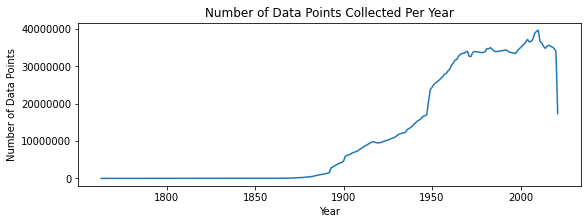

In [261]:
plt.figure(figsize=(9, 3))
plt.plot(years, sample_points);
plt.title("Number of Data Points Collected Per Year")
plt.ticklabel_format(style = 'plain')
plt.xlabel("Year")
plt.ylabel("Number of Data Points");

In [262]:
# Massively plots elements per year for each id
"""
for _id in tqdm(stations["ID"]):
    for element in elements:
        for year in years:
            plotter.remote(dfs[year], _id, element, save=True, year=year)
"""

'\nfor _id in tqdm(stations["ID"]):\n    for element in elements:\n        for year in years:\n            plotter.remote(dfs[year], _id, element, save=True, year=year)\n'

We can also analyze what type of weather data is being collected. Here is a plot of the top 25 weather data being collected ranked by frequency.

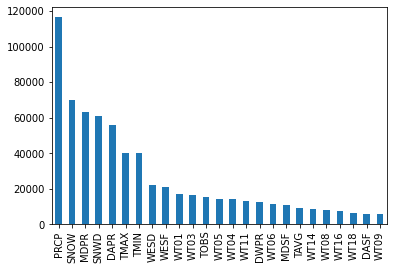

In [317]:
inventory["ELEMENT"].value_counts().head(25).plot(kind="bar");

Next, let's analyze and plot data from a weather station. We will analyze the station USC00040693 in Berkeley, CA [(Google Maps)](https://www.google.com/maps/place/37°52'27.8%22N+122°15'38.2%22W/@37.8744024,-122.2618614,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d37.8744!4d-122.2606). Through Pandas/modin, we can figure out which elements of weather data this station records:

In [281]:
inventory[inventory["ID"] == 'USC00040693']

,ID,LATITUDE,LONGITUDE,ELEMENT,FIRSTYEAR,LASTYEAR
388869,USC00040693,37.8744,-122.2606,TMAX,1893,2021
388870,USC00040693,37.8744,-122.2606,TMIN,1893,2021
388871,USC00040693,37.8744,-122.2606,TOBS,1901,2020
388872,USC00040693,37.8744,-122.2606,PRCP,1893,2021
388873,USC00040693,37.8744,-122.2606,SNOW,1899,2010
388874,USC00040693,37.8744,-122.2606,SNWD,1913,2010
388875,USC00040693,37.8744,-122.2606,DAPR,1953,2012
388876,USC00040693,37.8744,-122.2606,MDPR,1953,2012
388877,USC00040693,37.8744,-122.2606,WT01,1893,1997
388878,USC00040693,37.8744,-122.2606,WT03,1915,1988


Data will vary a lot between stations, some stations may record as little as just precipitation. Coincidentally, this weather station is located on UC Berkeley campus and has been recording data of various elements for quite a while. Let's load all the data of each element into a dictionary and analyze the data:

In [292]:
berkeley_weather_elements

,ELEMENT,FIRSTYEAR,LASTYEAR
388869,TMAX,1893,2021
388870,TMIN,1893,2021
388871,TOBS,1901,2020
388872,PRCP,1893,2021
388873,SNOW,1899,2010
388874,SNWD,1913,2010
388875,DAPR,1953,2012
388876,MDPR,1953,2012
388877,WT01,1893,1997
388878,WT03,1915,1988


In [304]:
#TODO: Make dataloading faster by batching operations if possible. Currently 7-8s per iteration
berkeley_weather_elements = inventory[inventory["ID"] == 'USC00040693'][["ELEMENT", "FIRSTYEAR", "LASTYEAR"]]
berkeley_time_series = {}

for _, rows in berkeley_weather_elements.iterrows():
    element, firstyear, lastyear = rows
    berkeley_time_series[element] = df_filter_vector('USC00040693', element, local=True, custom_years=(firstyear, lastyear))

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

We can plot data in the last 3 years, (plotting all of the data will take a long time due to the bottleneck of matplotlib).

<AxesSubplot:xlabel='YEAR/MONTH/DAY'>

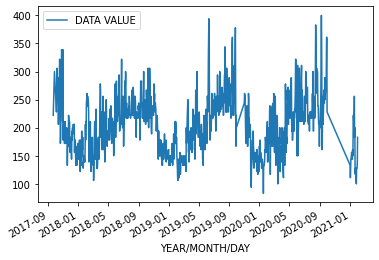

In [314]:
berkeley_time_series["TMAX"].tail(365 * 3).plot()

<AxesSubplot:xlabel='YEAR/MONTH/DAY'>

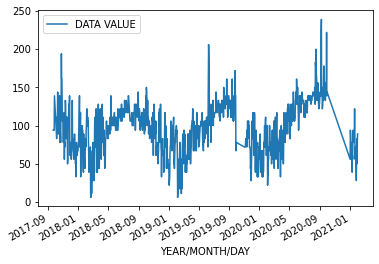

In [315]:
berkeley_time_series["TMIN"].tail(365 * 3).plot()

<AxesSubplot:xlabel='YEAR/MONTH/DAY'>

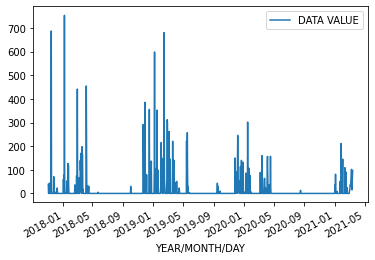

In [311]:
berkeley_time_series["PRCP"].tail(365 * 3).plot()

<AxesSubplot:xlabel='YEAR/MONTH/DAY'>

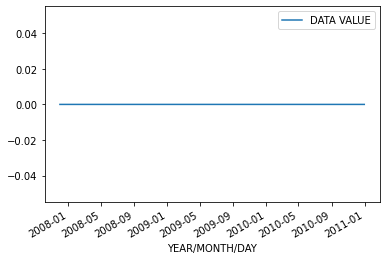

In [312]:
berkeley_time_series["SNOW"].tail(365 * 3).plot()

## Modeling
#TODO: Refactor modeling portion to a separate notebook after done experimenting
### Linear Regression

In [342]:
def rmse(actual, expected):
    if type(actual) != type(expected):
        raise TypeError
    if type(actual) == numpy.ndarray:
        return np.sqrt(np.mean((expected - actual) ** 2))
    elif type(actual) == nums.core.array.blockarray.BlockArray:
        return nps.sqrt(nps.mean((expected - actual) ** 2))
    elif type(actual) == modin.pandas.dataframe.DataFrame or type(actual) == pandas.core.frame.DataFrame:
        #TODO
        raise NotImplementedError
    else:
        raise TypeError

In [52]:
from nums.experimental import nums_modin

In [144]:
def create_design_matrix(_id, element, years, convert_nps=True, local=False):
    """
    Inputs are station ID and element
    Output is a design matrix, in NumS array or Pandas DataFrame
    """
    df_design = pd.DataFrame(columns=pd.date_range(start="2020-01-01", end="2020-12-31").strftime('%m-%d'))
    station_name = stations.loc[stations['ID'] == _id]["NAME"].item()
    
    for year in tqdm(years):
        if local:
            df = dfs[year]
        else:
            try:
                df = df_loader(year)
            except ClientError:
                tqdm.write(str(year) + ".csv doesn't exist on remote, addition to design matrix is skipped.")
                continue
            
        df = df_filter(df, _id, element)
        if df.empty:
            tqdm.write(element + " data on " + str(year) + " for " + station_name + " with id: " + _id + " is empty. Addition to design matrix is skipped.")
            continue
        df.index = df.index.strftime('%m-%d')
        df.columns = [year]
        df = df.T
        df_design = df_design.append(df)


    df_design.index.name = None
    if convert_nps:
        #return nums_modin.from_modin(df_design.astype(int)) 
        """
        TODO: Bug? Fails at:
        ----> 1 nums_modin.from_modin(design_matrix.astype(np.int64))

        ~/external/nums/nums/experimental/nums_modin.py in from_modin(df)
             60         if type(frame.dtypes.dtype) == np.dtype:
             61             continue
        ---> 62         assert dt == frame.dtypes
             63     dtype = np.__getattribute__(str(dtype))
             64 

        AssertionError: 
        """
        return nps.array(df_design.to_numpy().astype(np.double))
    return df_design

In [145]:
#Test to see if design matrix works
design_matrix = create_design_matrix('EZE00100082', 'TMAX', years, local=True)

  0%|          | 0/259 [00:00<?, ?it/s]

TMAX data on 1763 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1764 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1765 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1766 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1767 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1768 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1769 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1770 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1771 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1772 f

TMAX data on 2006 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2007 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2008 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2009 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2010 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2011 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2012 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2013 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2014 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2015 f

In [146]:
np.save("test.npy", design_matrix.get())

In [53]:
design_matrix = nps.array(np.load("test.npy"))

In [201]:
design_matrix.shape

In [202]:
A = nps.nan_to_num(design_matrix)
y = nps.arange(1775, design_matrix.shape[0] + 1775, 1)
#y = nps.arange(1, 367, 1)
y.shape

(230,)

test modeling with sklearn

In [203]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(A.get(), y.get())
sklearn_coef = model.coef_

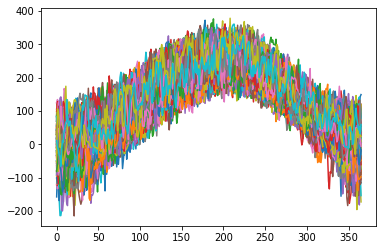

In [204]:
for i in range(A.shape[0]):
    plt.plot(A[i].get())

We can also use PCA to detect any anomalties in the data.

In [205]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

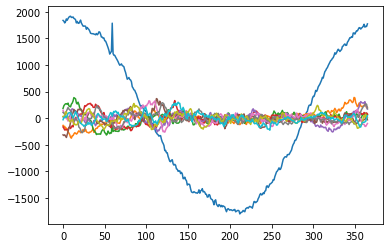

In [206]:
plt.plot(pca.fit_transform(A.T.get()));

In [207]:
pca.explained_variance_ratio_

array([0.80875209, 0.00888328, 0.00775458, 0.00595863, 0.00560225,
       0.00515499, 0.00480058, 0.00464728, 0.00432136, 0.00419639])

In [70]:
model.predict(A.T.get())

array([ 11.22544643, -11.39701756,  27.85382419, -20.80285796,
        23.94157638,  11.40298083,  12.09276171,  24.24316084,
        22.66869712, -20.24946541,   7.818794  ,  25.50337546,
         8.65191324,   3.1242617 ,  42.13707677,  18.56022956,
        15.10400813, -19.05559764,  34.70490197,  22.98622813,
        29.61296812,  30.32066065,  28.91341826,  -7.57697434,
        19.22860071,  29.73779187,  20.11514675,  44.99971802,
        29.22262733,   3.0114597 ,  13.62014022,  43.49648153,
        31.40635413,  16.40835786,  58.51504472,  28.9413034 ,
        53.42651624,  52.48566979,   6.1861793 ,  52.17528266,
        70.66437875,  37.31046956,  25.24377327,  73.11381063,
        44.77725763,  22.67077448,  58.22805161,  54.37781247,
        55.36788513,  64.42747089,  42.47747741,  56.50161302,
        26.51044255,  35.16485747,  75.15855502,  88.68624745,
        56.09914193,  51.01559368,  45.71636336,  44.41218873,
        53.11226924,  84.93277644,  90.67358738,  37.70

In [152]:
result1, result2, result3, result4 = np.linalg.lstsq(A.get(), y.get(), rcond=None)
result1.shape

(366,)

In [153]:
from nums.models.glms import LinearRegression

In [154]:
LinearRegression

nums.models.glms.LinearRegression

In [155]:
model = LinearRegression()
model.fit(A, y)

In [158]:
model._beta.get();

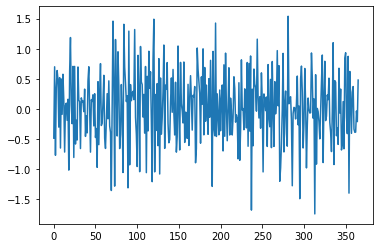

In [157]:
plt.plot(sklearn_coef)

In [ ]:
model.predict(design_matrix[0]).get()

In [ ]:
block_shape = design_matrix.T.block_shape
shape = design_matrix.T.shape
R_shape = (shape[1], shape[1])
R_block_shape = (block_shape[1], block_shape[1])

### Simple modeling with FFT

Using FFT to forecast seasonal weather patterns
Source: https://gist.github.com/tartakynov/83f3cd8f44208a1856ce

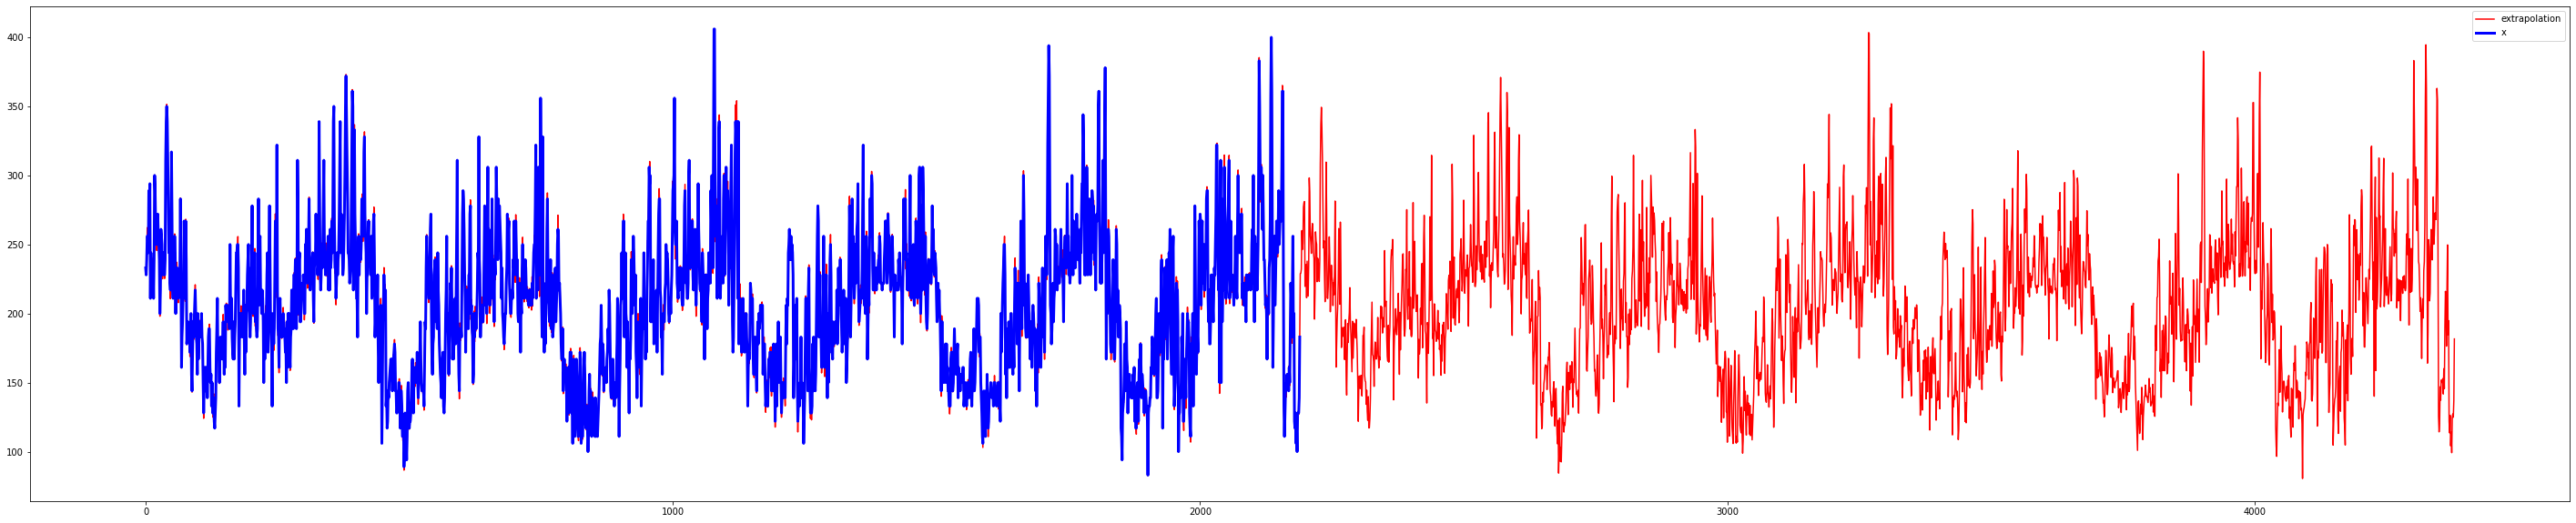

In [329]:
from numpy import fft
import numpy as np
    
def fourierExtrapolation(x, n_predict, n_harm=100):
    n = x.size
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t
    

x = berkeley_time_series["TMAX"].tail(365 * 6).to_numpy().reshape(-1)
n_predict = 365 * 6
extrapolation = fourierExtrapolation(x, n_predict, n_harm=1000)
plt.figure(figsize=(50, 10))
plt.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
plt.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
plt.legend()
plt.savefig("fft_berkeley_tmax.png")

In [333]:
rmse(x, extrapolation[:x.shape[0]])

4.890433653667803

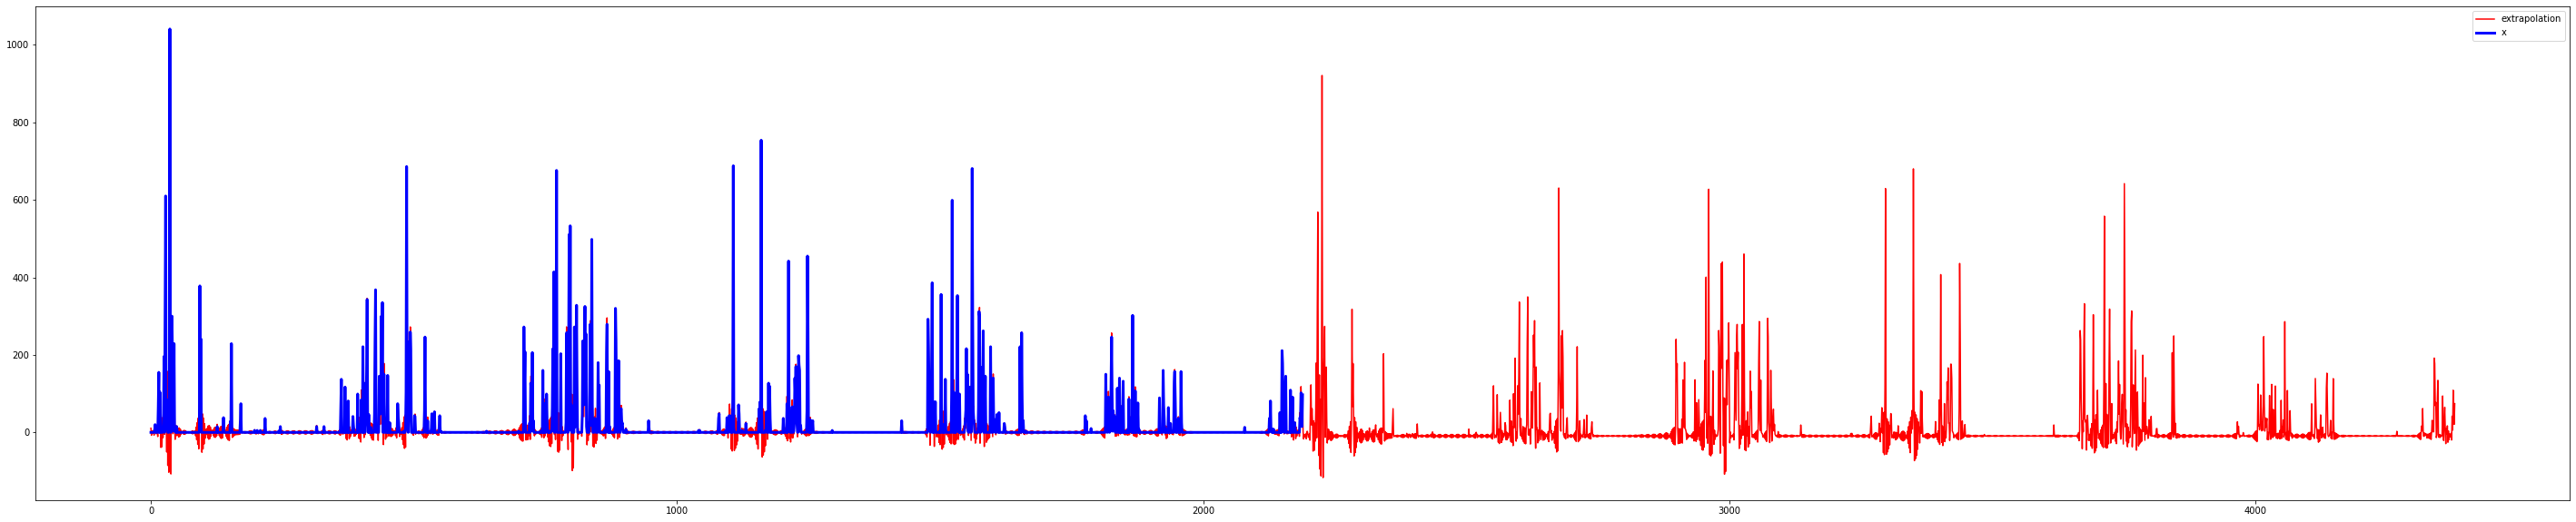

In [334]:
x = berkeley_time_series["PRCP"].tail(365 * 6).to_numpy().reshape(-1)
n_predict = 365 * 6
extrapolation = fourierExtrapolation(x, n_predict, n_harm=1000)
plt.figure(figsize=(50, 10))
plt.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
plt.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
plt.legend()
plt.savefig("fft_berkeley_prcp.png")

In [335]:
rmse(x, extrapolation[:x.shape[0]])

16.79415463941455

### Modeling using GreyKite

In [49]:
import greykite

In [176]:
elements

['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']

In [183]:
df_filter(dfs[2000], "CA006158350", "PRCP")

,DATA VALUE
YEAR/MONTH/DAY,
2000-01-01,0
2000-01-02,18
2000-01-03,46
2000-01-04,0
2000-01-05,0
...,...
2000-12-27,0
2000-12-28,0
2000-12-29,38


In [190]:
elements

['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']

In [ ]:
def create_time_series_design_matrix(_id, element, features):
    df = pd.DataFrame(columns=features)
    for year in tqdm(years):
        

In [196]:
df = pd.DataFrame(columns=elements)
#for year in tqdm(years):
year = 2000
for feature in ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']:
    df[feature] = df_filter(dfs[year], "CA006158350", feature)

In [203]:
A = nps.array(df[['PRCP', 'TMAX', 'TMIN']].to_numpy())

In [204]:
y = nps.array(df['SNOW'].to_numpy())

In [205]:
from nums.models.glms import LogisticRegression

In [206]:
model = model.fit(A, y)

AttributeError: 'NoneType' object has no attribute 'fit'

In [ ]:
%%time
tmin = climate_2020[climate_2020["ELEMENT"] == "TMIN"]
tmax = climate_2020[climate_2020["ELEMENT"] == "TMAX"]

In [ ]:
precipication["DATA VALUE"].plot()

In [ ]:
snow = climate_2020[climate_2020["ELEMENT"] == "SNOW"]
snow_depth = climate_2020[climate_2020["ELEMENT"] == "SNWD"]

In [ ]:
snow["DATA VALUE"].plot()

In [ ]:
snow = climate_2020[climate_2020["ELEMENT"] == "SNOW"]

In [ ]:
climate_2020["country_code"] = climate_2020["ID"].str.slice(stop=2)

In [ ]:
climate_2020

In [ ]:
climate_2020[climate_2020["country_code"] == "US"]

In [ ]:
climate_2020[climate_2020["ID"] == "US10adam002"]

In [ ]:
climate_2020[climate_2020["ID"] == "US10adam002"].plot(x = "YEAR/MONTH/DAY", y="DATA VALUE")
climate_2020[climate_2020["ID"] == "USW00096408"].plot(x = "YEAR/MONTH/DAY", y="DATA VALUE")
climate_2020[climate_2020["ID"] == "US10adam002"].plot(x = "YEAR/MONTH/DAY", y="DATA VALUE")

When done, run this so you can properly shutdown Ray

In [247]:
ray.shutdown()